# Store Item Demand Forecasting Challenge - kaggle

## Description

##### Problem

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

This is a great competition to explore different models and improve your skills in forecasting

##### Evaluation
Submissions are evaluated on SMAPE between forecasts and actual values. We define SMAPE = 0 when the actual and predicted values are both 0.

## Packages

In [189]:
import pandas as pd 
import numpy as np 

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import statsmodels.api as sm

color = sns.color_palette()
sns.set_style('darkgrid')

from statsmodels.tsa.stattools import adfuller

## Functions

In [190]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    """
    Function to sets for stationarity in a time series 
    """

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

## EDA

In [191]:
train = pd.read_csv(r'data/train.csv')
test = pd.read_csv(r'data/test.csv')

In [192]:
# Change date to datetime
train['date'] = pd.to_datetime(train['date'])

# View dataframe
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [193]:
# Check descriptive stats
train.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [194]:
print(f"The earliest date in the set is {train.date.min()}")
print("---------------------------")
print(f"The latest date in the set is {train.date.max()}")

The earliest date in the set is 2013-01-01 00:00:00
---------------------------
The latest date in the set is 2017-12-31 00:00:00


## Timeseries evaluation

In [195]:
# Adding date features
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]
# train_df = train_df.set_index('date')
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


### Decompose the time series

<AxesSubplot: xlabel='date', ylabel='sales'>

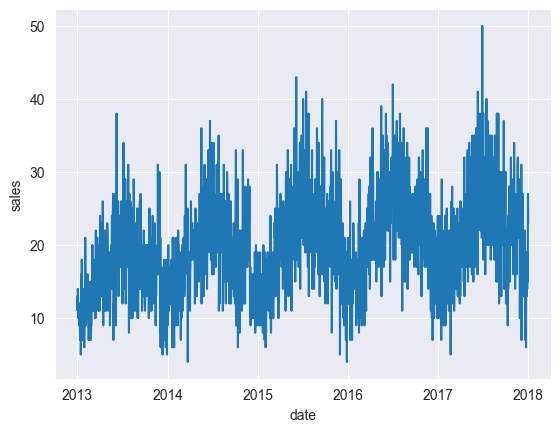

In [196]:
# Plot full series
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

<AxesSubplot: xlabel='date', ylabel='sales'>

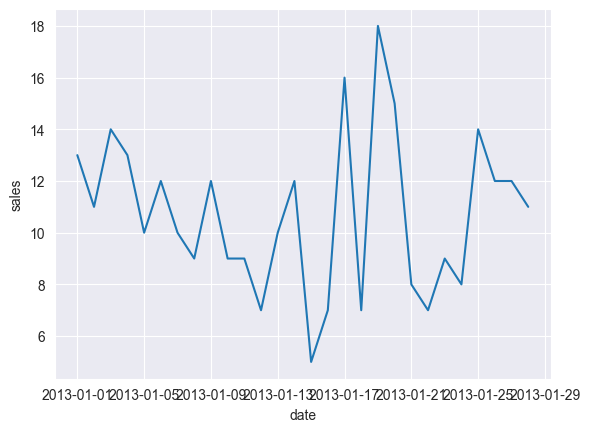

In [197]:
# Plot - first month
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

<AxesSubplot: xlabel='weekday', ylabel='sales'>

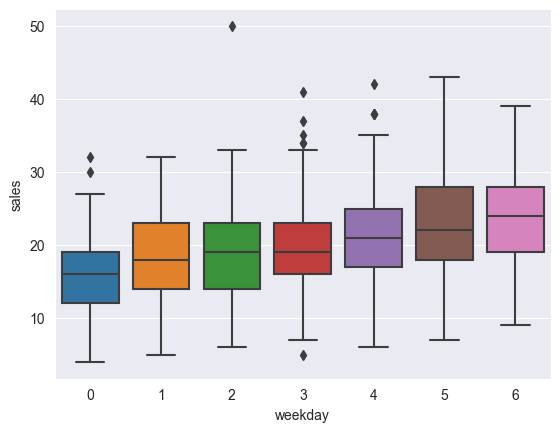

In [198]:
sns.boxplot(x="weekday", y="sales", data=train_df)

We can see higher sales as the week progresses, peaking on saturdays.

We can also see outliers on mondays, wednesdays and thursdays.

In [199]:
# Making the dataframe into a time series by setting the date column as the index
train_df = train_df.set_index('date')
# Converting sales to decimal
train_df['sales'] = train_df['sales'].astype(float)

train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


<Figure size 640x480 with 0 Axes>

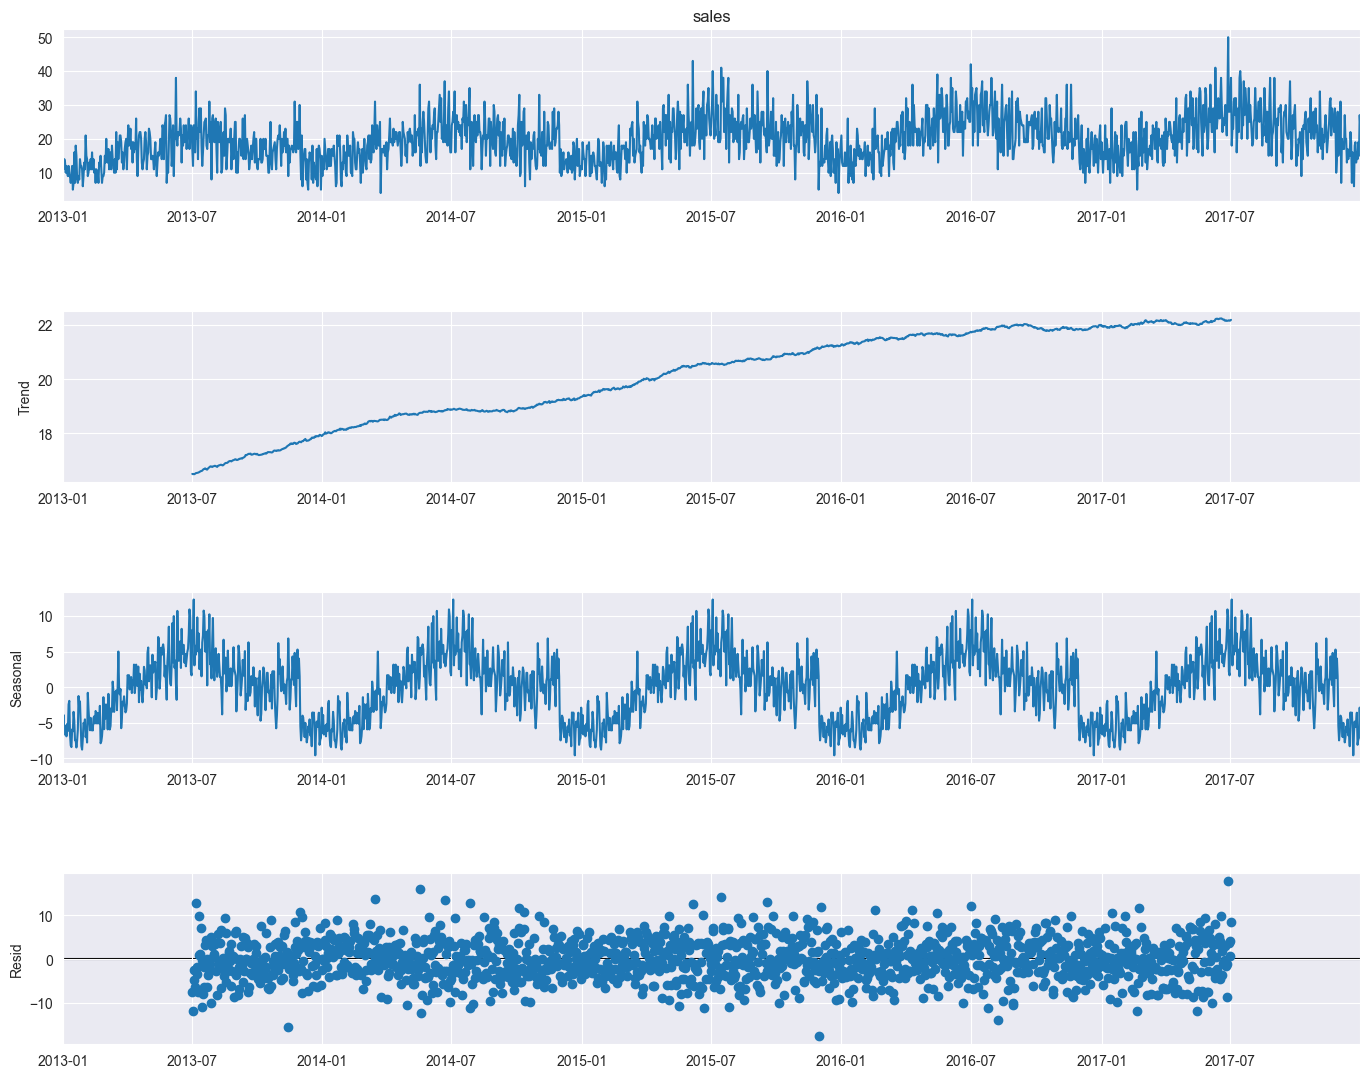

In [200]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', period=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

### Checking for stationarity

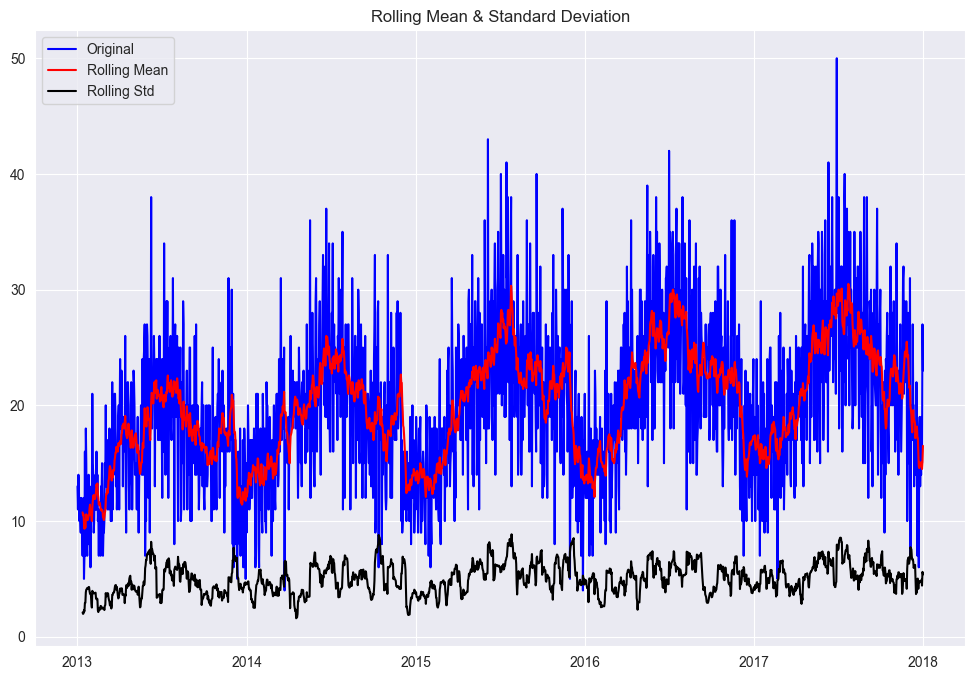

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [201]:
test_stationarity(train_df['sales'])

### Differencing

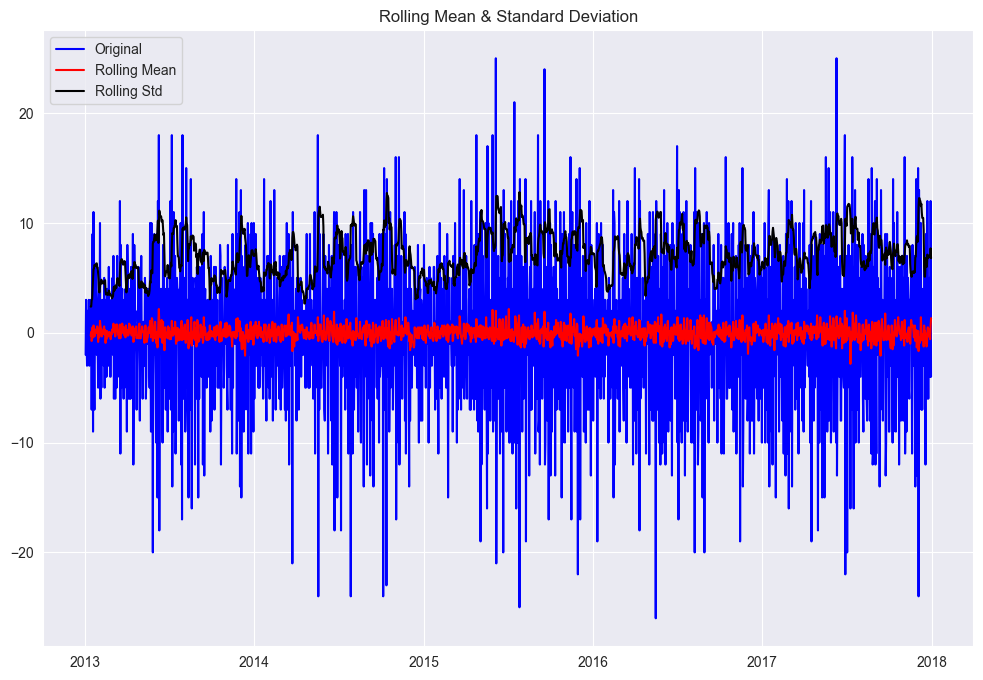

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [202]:
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)

# Retest for stationairity
test_stationarity(first_diff, window = 12)

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) 

Plotting acf and pacf on original dataset:

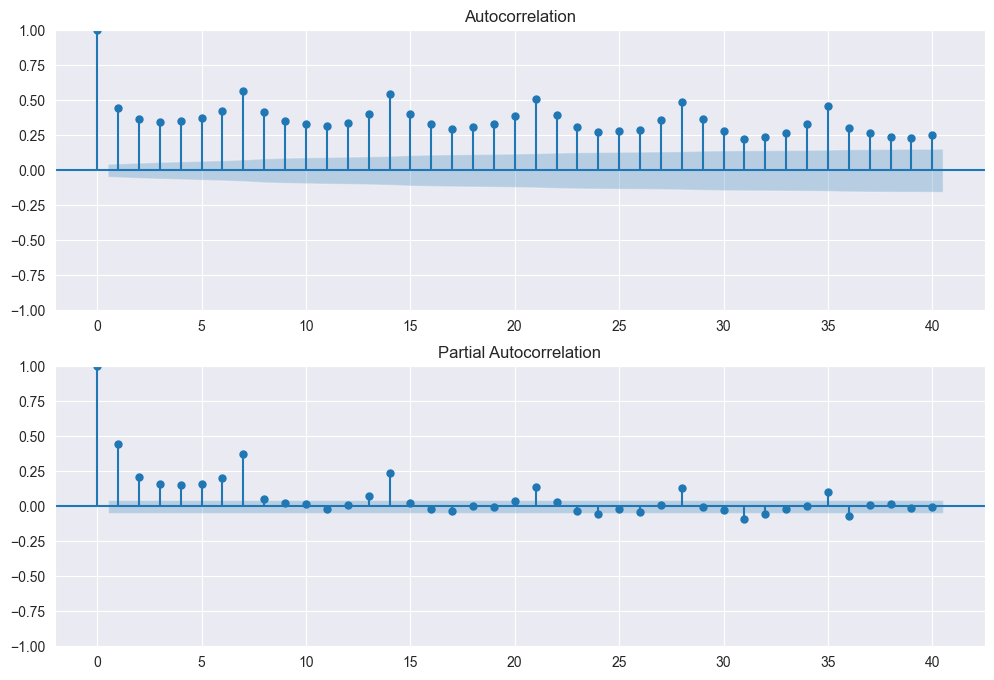

In [203]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)# , lags=40

Plotting acf and pacf on diff'd dataset:

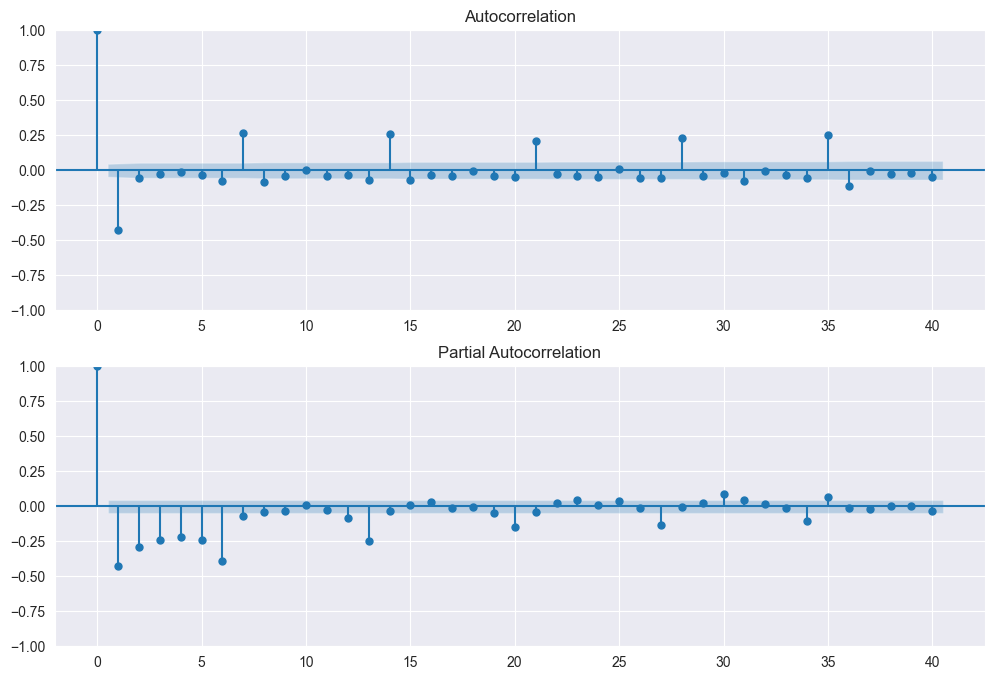

In [204]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. 

Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont.

## Modelling

In [205]:
train_df.sales

date
2013-01-01    13.0
2013-01-02    11.0
2013-01-03    14.0
2013-01-04    13.0
2013-01-05    10.0
              ... 
2017-12-27    14.0
2017-12-28    19.0
2017-12-29    15.0
2017-12-30    27.0
2017-12-31    23.0
Name: sales, Length: 1826, dtype: float64

In [206]:
arima_mod6 = sm.tsa.arima.ARIMA(train_df.sales, order=(6, 1, 0))
res = arima_mod6.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.679
Date:                Wed, 05 Oct 2022   AIC                          11209.359
Time:                        20:52:12   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.74269014682373, pvalue=0.00023140408882618588)


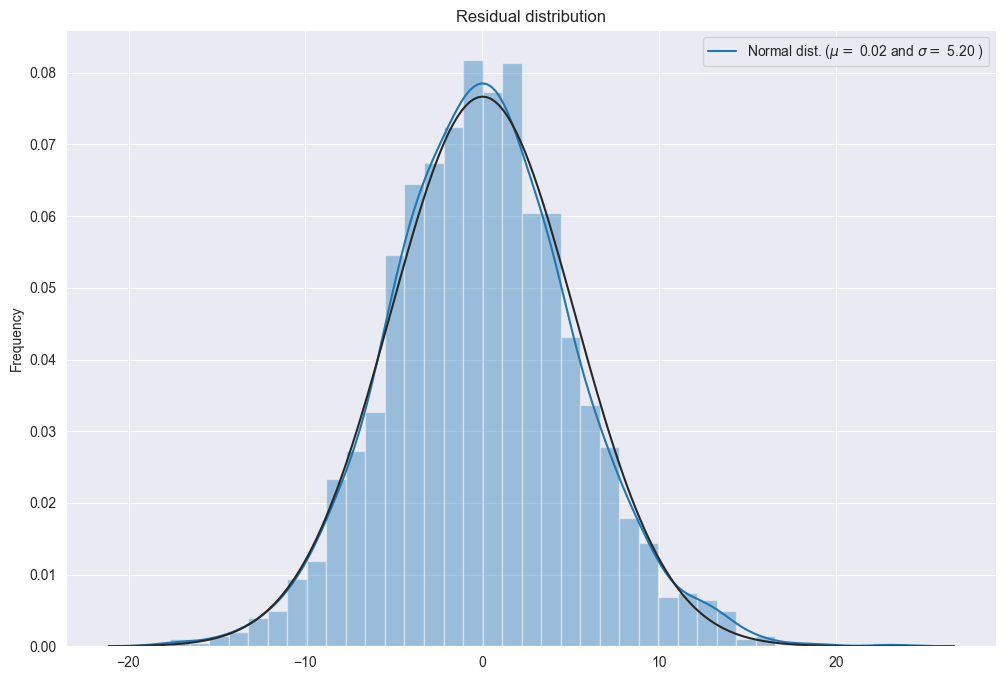

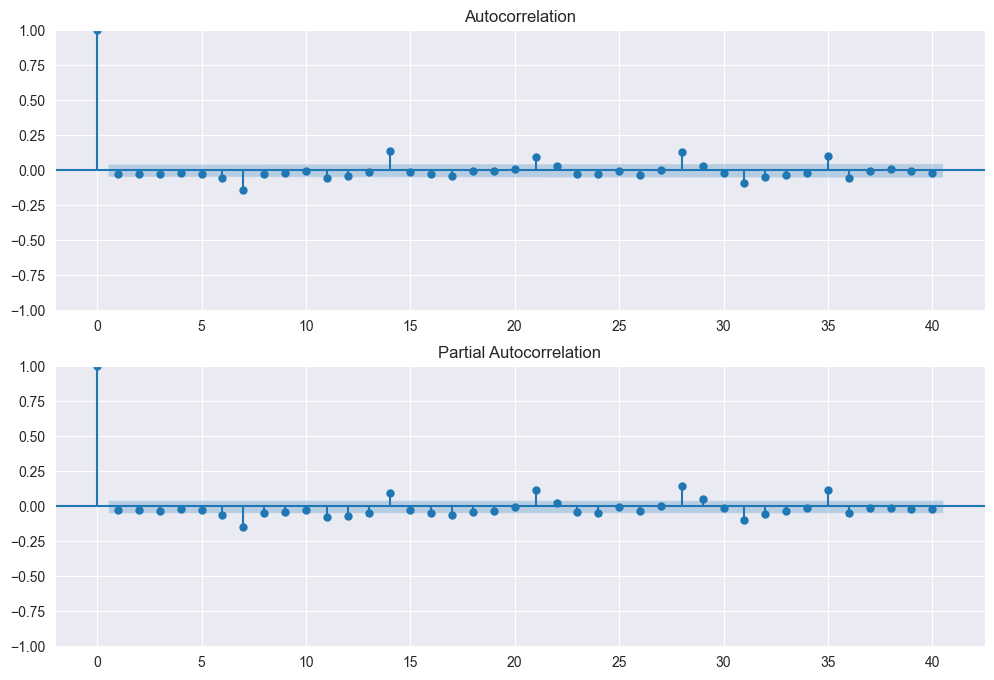

In [207]:
from scipy import stats
from scipy.stats import normaltest

resid = res.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

Although the graph looks very like a normal distribution. But it failed the test. Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality

In [208]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Wed, 05 Oct 2022   AIC                          11209.359
Time:                        20:52:13   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.74269014682373, pvalue=0.00023140408882618588)


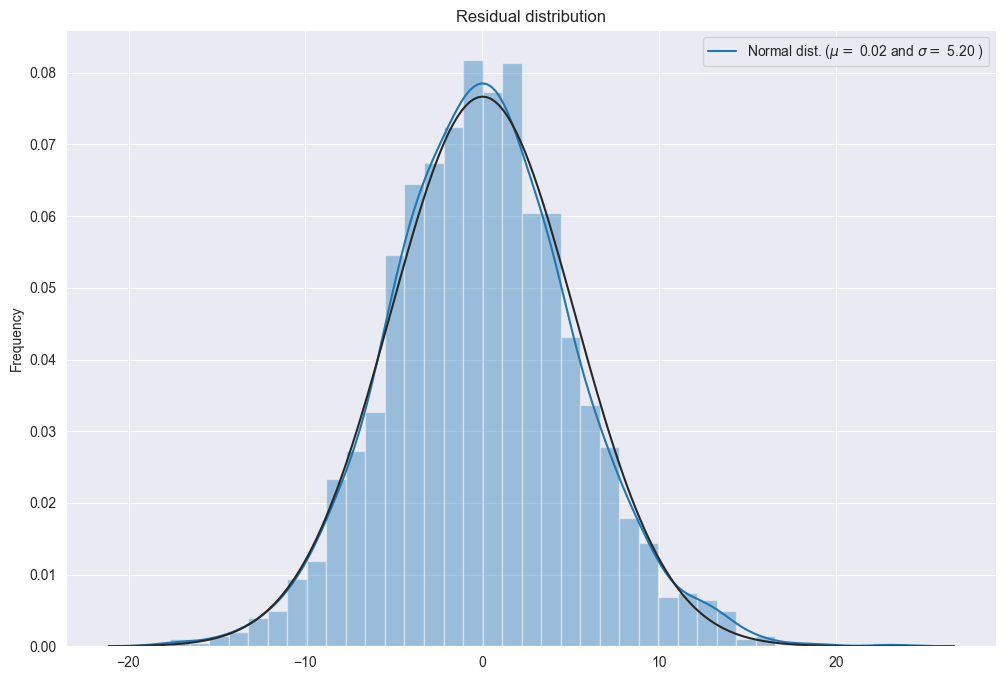

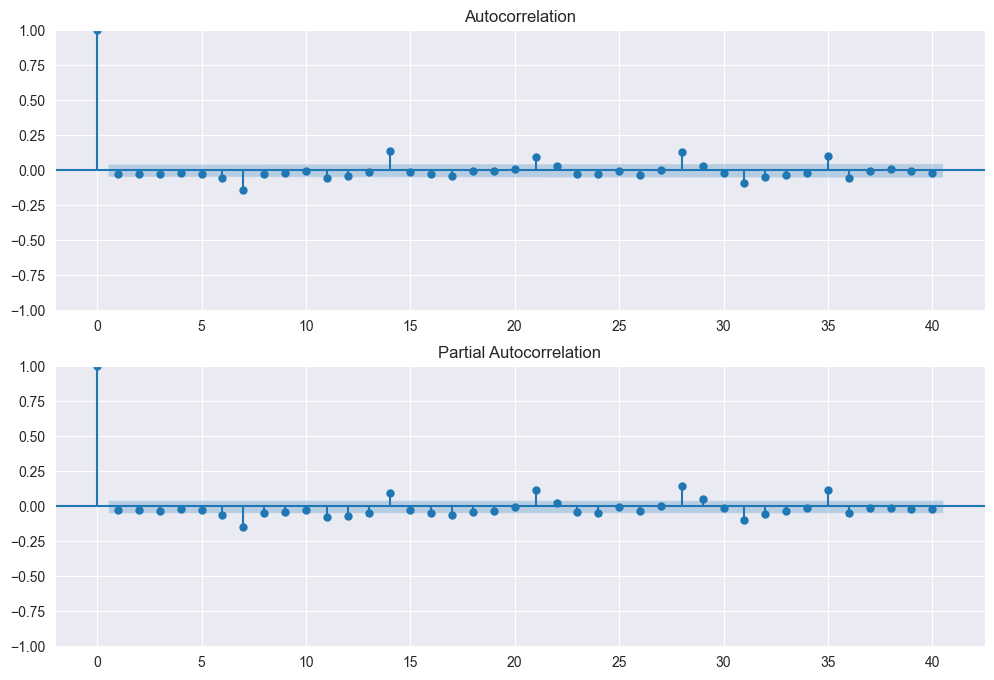

In [209]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)


## Make prediction and evaluation

Take the last 30 days in training set as validation data

<AxesSubplot: xlabel='date'>

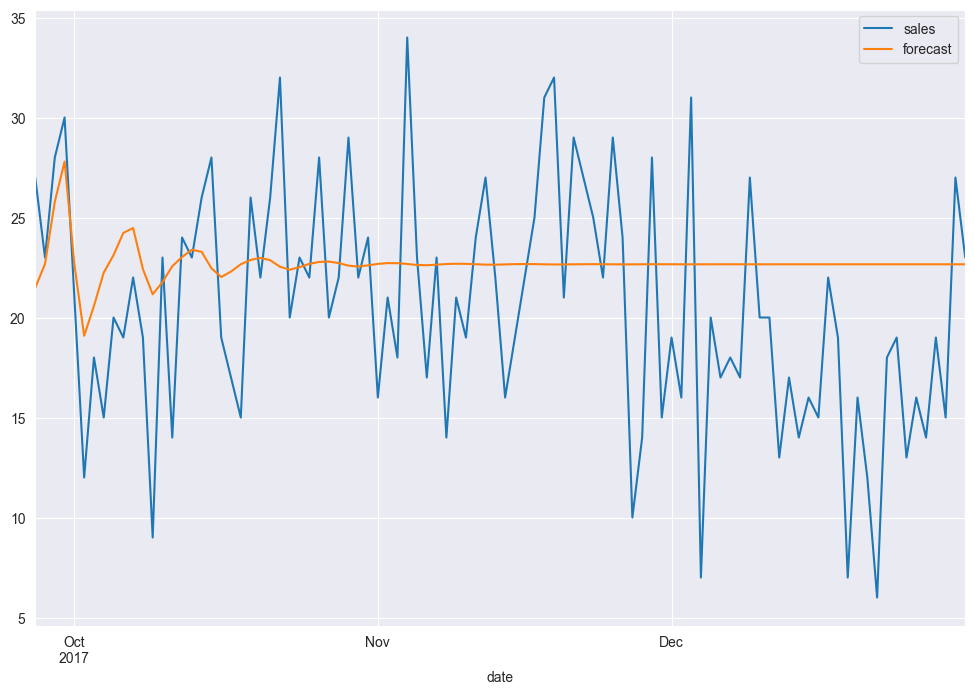

In [210]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [211]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [212]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


### SARIMAX: adding external variables

In [213]:
# per 1 store, 1 item
storeid = 1
itemid = 1
train_df = train[train['store']==storeid]
train_df = train_df[train_df['item']==itemid]

# train_df = train_df.set_index('date')
train_df['year'] = train_df['date'].dt.year - 2012
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear
train_df['weekday'] = train_df['date'].dt.weekday

start_index = 1730
end_index = 1826

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,1,1,1,1
1,2013-01-02,1,1,11,1,1,2,2
2,2013-01-03,1,1,14,1,1,3,3
3,2013-01-04,1,1,13,1,1,4,4
4,2013-01-05,1,1,10,1,1,5,5


In [218]:
holiday = pd.read_csv(r'data/USholidays.csv',header=None, names = ['date', 'holiday'])
holiday['date'] = pd.to_datetime(holiday['date'], yearfirst = True)
holiday.head()

,date,holiday
1,2012-01-02,New Year Day
2,2012-01-16,Martin Luther King Jr. Day
3,2012-02-20,Presidents Day (Washingtons Birthday)
4,2012-05-28,Memorial Day
5,2012-07-04,Independence Day


In [220]:
train_df = train_df.merge(holiday, how='left', on='date')
train_df['holiday_bool'] = pd.notnull(train_df['holiday']).astype(int)
train_df = pd.get_dummies(train_df, columns = ['month','holiday','weekday'] , prefix = ['month','holiday','weekday'])
# train_df.head()
# train_df.shape
# train_df.columns

In [221]:
ext_var_list = ['date','year', 'day', 'holiday_bool',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'holiday_Christmas Day', 'holiday_Columbus Day',
       'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King Jr. Day', 'holiday_Memorial Day',
       'holiday_New Year Day', 'holiday_Presidents Day (Washingtons Birthday)',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6']

In [222]:
exog_data = train_df[ext_var_list]
exog_data = exog_data.set_index('date')
exog_data.head()

,year,day,holiday_bool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,holiday_Presidents Day (Washingtons Birthday),holiday_Thanksgiving Day,holiday_Veterans Day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,1,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,1,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,1,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,1,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [223]:
train_df = train_df.set_index('date')
# train_df = train_df.reset_index()
train_df.head()

,store,item,sales,year,day,holiday_bool,month_1,month_2,month_3,month_4,...,holiday_Presidents Day (Washingtons Birthday),holiday_Thanksgiving Day,holiday_Veterans Day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,1,1,11,1,2,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,1,1,14,1,3,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,1,1,13,1,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,1,1,10,1,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [224]:
start_index = '2017-10-01'
end_index = '2017-12-31'
# exog_data.head()

In [227]:
sarimax_mod6 = sm.tsa.statespace.SARIMAX(endog = train_df.sales[:start_index],
                                        exog = exog_data[:start_index],  
                                        trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
print(sarimax_mod6.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1735
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -5133.382
Date:                             Wed, 05 Oct 2022   AIC                          10346.763
Time:                                     20:58:15   BIC                          10564.929
Sample:                                 01-01-2013   HQIC                         10427.465
                                      - 10-01-2017                                         
Covariance Type:                               opg                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
year                                

In [228]:
start_index = '2017-10-01'
end_index = '2017-12-30'
end_index1 = '2017-12-31'

<AxesSubplot: xlabel='date'>

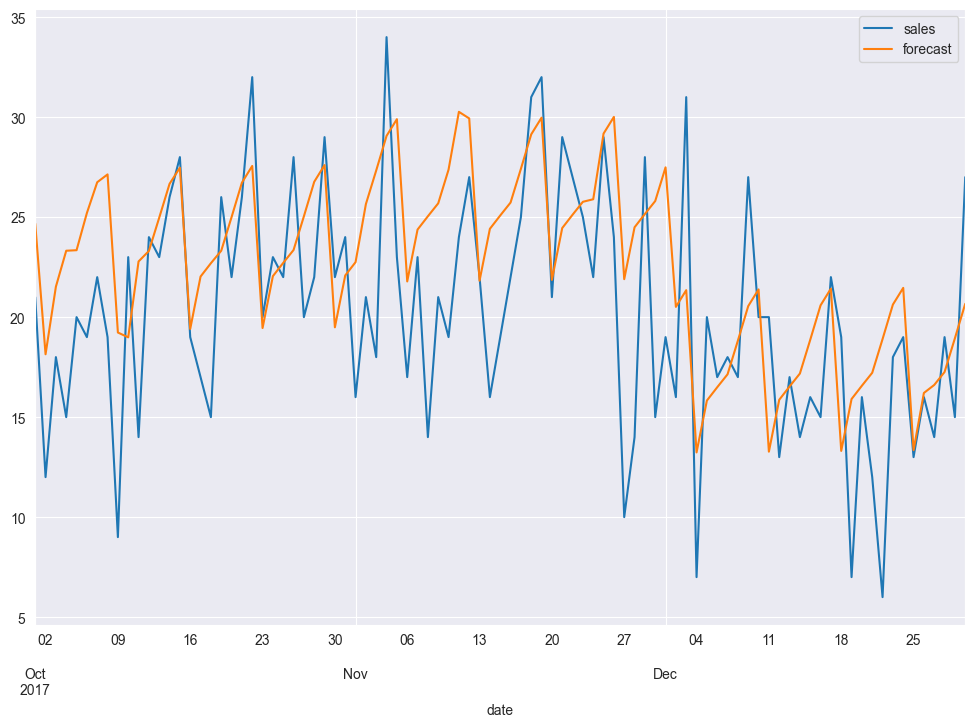

In [230]:
train_df['forecast'] = sarimax_mod6.predict(start = pd.to_datetime(start_index), end= pd.to_datetime(end_index1),
                                            exog = exog_data[start_index:end_index], 
                                            dynamic= True)  

train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [231]:
smape_kun(train_df[start_index:end_index]['sales'],train_df[start_index:end_index]['forecast'])

MAPE: 27.14 % 
SMAPE: 21.90 %
